In [2]:
library(ReactomePA)
library(dplyr)
library(org.Hs.eg.db)
library(ggplot2)
library(clusterProfiler)
library(repr)
library(biomaRt)
library(tidyr)
library(Matrix)
library(Seurat)
library(SingleCellExperiment)
library(DOSE)
library(ggpubr)
library(forcats)
#library(ggdendro)
#library(heatmaply)
options(repr.plot.width=50, repr.plot.height=10)



ReactomePA v1.34.0  For help: https://guangchuangyu.github.io/ReactomePA

If you use ReactomePA in published research, please cite:
Guangchuang Yu, Qing-Yu He. ReactomePA: an R/Bioconductor package for reactome pathway analysis and visualization. Molecular BioSystems 2016, 12(2):477-479


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setd

In [213]:
setwd("/home/jovyan/data/GCA/R_conversion")
gca<-readRDS("GCA_R.RDS")

In [214]:
Idents(gca)<-'tissue'
gca_tissue<-subset(gca, id = 'tissue')

In [215]:
Idents(gca_tissue)<-'anno'
gca_tissue<-subset(gca_tissue, id = '', invert = TRUE)

In [216]:
Idents(gca_tissue)<-'anno'
markers<-FindAllMarkers(gca_tissue, logfc.threshold = 0.25, min.pct = 0.25, only.pos = TRUE)

Calculating cluster MyoFB_tissue

Calculating cluster VSMC_tissue

Calculating cluster Mac1_tissue

Calculating cluster CD4_1_tissue

Calculating cluster Transitional_tissue

Calculating cluster NK_tissue

Calculating cluster Mac2_tissue

Calculating cluster Endothelium_2_tissue

Calculating cluster Endothelium_1_tissue

Calculating cluster CD8_tissue

Calculating cluster Lymph_endo_tissue

Calculating cluster CD4_2_tissue

Calculating cluster DC_tissue

Calculating cluster Epithelium_tissue

Calculating cluster Plasma_tissue

Calculating cluster CD4_exhausted_tissue

Calculating cluster Melanocyte_tissue

Calculating cluster Muscle_tissue



In [217]:
markers$cluster<-gsub('_tissue', '', markers$cluster)

In [218]:
setwd("/home/jovyan/data/GCA/stats")
write.csv(markers, 'initial_clustering_DEGs.csv')


***Restart***


In [211]:
setwd("/home/jovyan/data/GCA/stats")
markers<-read.csv('initial_clustering_DEGs.csv')

In [220]:
markers<-markers %>% filter(p_val_adj<0.05)

In [203]:
ensembl_gene <-
  useMart("ENSEMBL_MART_ENSEMBL", 
          host="https://grch37.ensembl.org",
          path="/biomart/martservice", 
          dataset = "hsapiens_gene_ensembl")

t2g<-biomaRt::getBM(attributes=c("external_gene_name","entrezgene_id"),mart=ensembl_gene)

In [204]:
colnames(t2g)<-c('gene', 'entrezgene_id')

In [221]:
markers<-left_join(x = markers, y = t2g, by = 'gene')

In [222]:
cells<-unique(markers$cluster)

In [223]:
l<-list()
for(i in 1:length(cells)){ 
    test<-markers[markers$cluster == cells[i],]
    l[cells[i]]<-list(test$entrezgene_id)
    }

In [18]:
OR_analysis<-data.frame()
for (i in 1:length(unique(cells))){
    tryCatch({
        temp <- enrichGO(gene = l[[i]],
                #universe      = names(geneList),
                OrgDb         = org.Hs.eg.db,
                ont           = "ALL",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05,
                readable      = TRUE)
        temp<-as.data.frame(temp)
        temp$celltype<-names(l[i])
        OR_analysis<-rbind(OR_analysis, temp)},
        error = function(e) {an.error.occured <<- TRUE})
    }

In [14]:
setwd("/home/jovyan/data/GCA/over-representation")
write.csv(OR_analysis, 'OR_analysis_by_celltype.csv')


***Plotting***


In [190]:
setwd("/home/jovyan/data/GCA/over-representation")
OR_analysis<-read.csv('OR_analysis_by_celltype.csv')

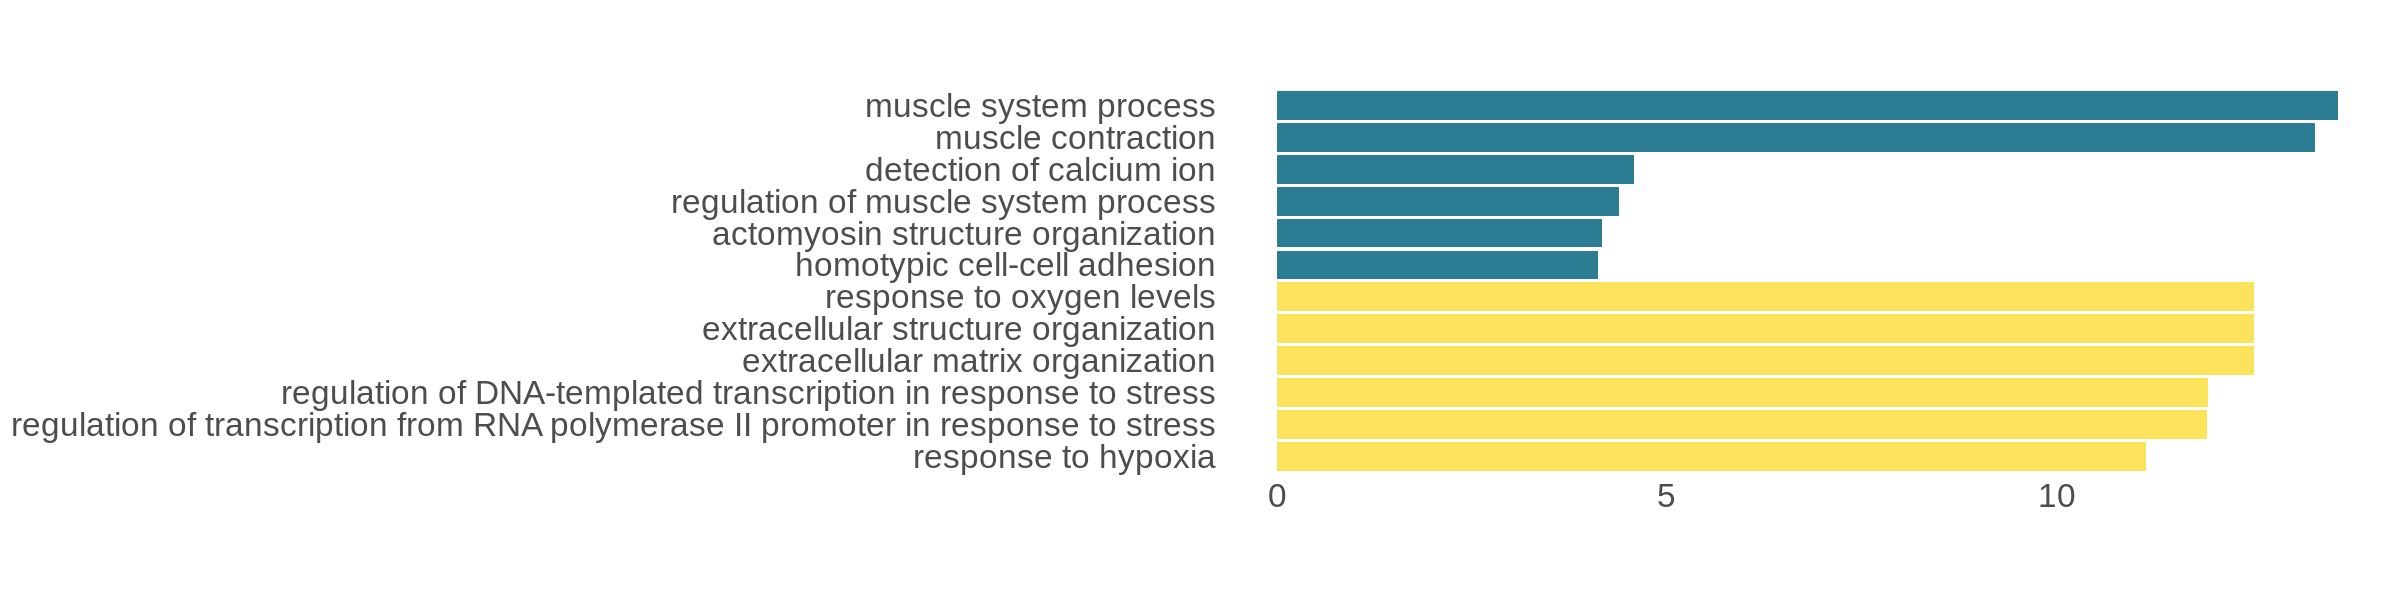

In [19]:
options(repr.plot.width=20, repr.plot.height=5)



temp<-OR_analysis %>% filter(celltype %in% c('MyoFB', 'VSMC')) %>% 
group_by(celltype) %>% filter(!grepl('vesicle', Description)) %>% filter(!grepl('platelet', Description)) %>% slice_head(n=6) 

temp$order<--log10(temp$p.adjust)
#temp<-within(temp, order[celltype=='MyoFB'] <- order*-1)

temp<-temp%>% mutate(Description = fct_reorder(Description, order))

ggplot(temp, aes(Description, order,  fill = celltype))+
geom_bar(stat="identity") +coord_flip()+
    theme(panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), 
    axis.line = element_blank(), 
    axis.ticks = element_blank(),
    text = element_text(size=15),
    aspect.ratio=1/3,
    axis.title=element_blank(),
    axis.text=element_text(size = 20),
    legend.position='none',
    strip.background = element_blank(),
    strip.text.x = element_blank()) + facet_wrap(~'celltype')+ 
scale_fill_manual(values = rev(c('#2c7c94', '#fbe45b')))


setwd('/home/jovyan/data/GCA/figures')
ggsave("OR_analysis.png", plot = last_plot(), device = NULL, path = NULL,width = 20, height = 5,  scale = 1)



In [ ]:


***Macrophage over-representation***



In [190]:
setwd("/home/jovyan/data/GCA/over-representation")
OR_analysis<-read.csv('OR_analysis_by_celltype.csv')

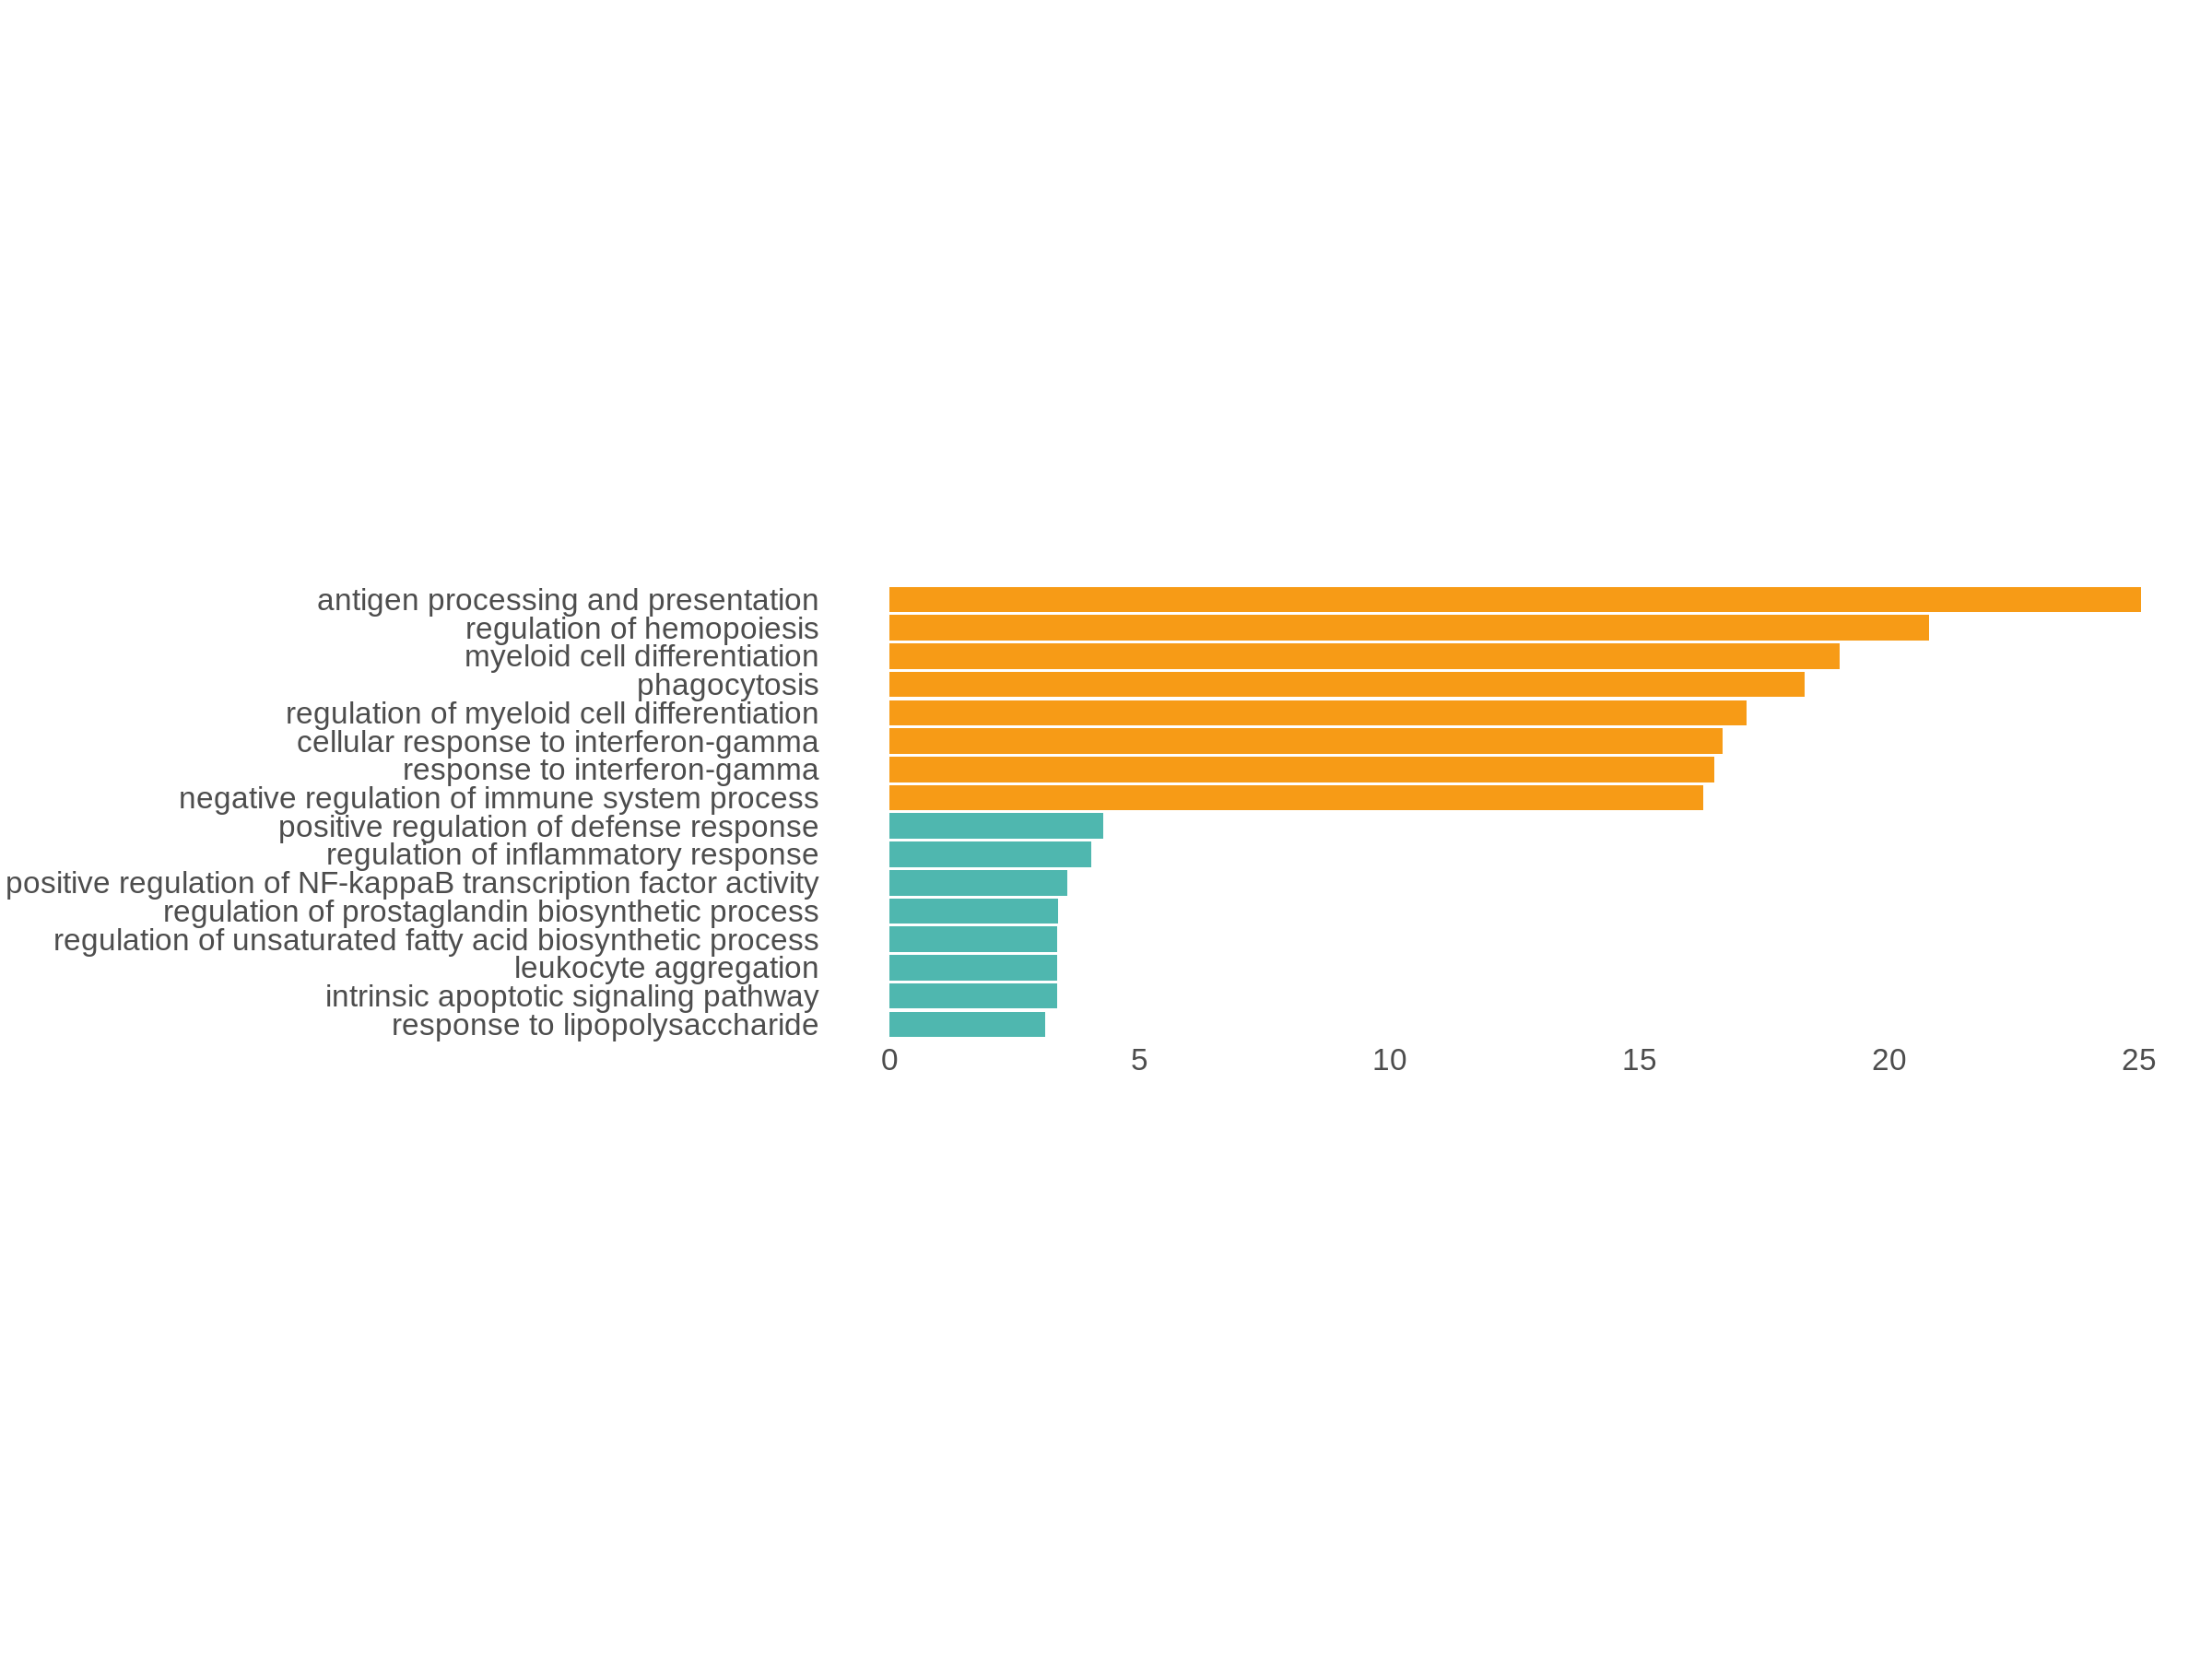

In [283]:
options(repr.plot.width=20, repr.plot.height=15)

OR_temp<-OR_analysis %>% 
filter(Description != 'positive regulation of inflammatory response')%>% 
filter(Description != 'antigen processing and presentation of exogenous antigen') %>%
filter(Description != 'negative regulation of megakaryocyte differentiation') %>%
filter(!grepl('vesicle', Description)) %>%
filter(!grepl('neutrophil', Description)) %>%
filter(!grepl('peptide', Description))

temp<-OR_temp %>% filter(celltype %in% c('Mac1', 'Mac2')) %>% 
group_by(celltype) %>% slice_head(n=8)

temp$celltype <- factor(temp$celltype, levels = rev(c("Mac1", 'Mac2')))


temp$order<--log10(temp$p.adjust)
#temp<-within(temp, order[celltype=='MyoFB'] <- order*-1)

temp<-temp%>% mutate(Description = fct_reorder(Description, order))



ggplot(temp, aes(Description, order,  fill = celltype))+
geom_bar(stat="identity") +coord_flip()+
    theme(panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), 
    axis.line = element_blank(), 
    axis.ticks = element_blank(),
    text = element_text(size=15),
    aspect.ratio=1/3,
    axis.title=element_blank(),
    axis.text=element_text(size = 20),
    legend.position='none',
    strip.background = element_blank(),
    strip.text.x = element_blank()) + facet_wrap(~'celltype')+ 
scale_fill_manual(values = rev(c('#f79b16', '#4fb7af')))


setwd('/home/jovyan/data/GCA/figures')
ggsave("OR_analysis_macrophages.png", plot = last_plot(), device = NULL, path = NULL,width = 20, height = 5,  scale = 1)

